# Cycle life prediction 🔮 using interpretable ML

### In this notebook, we are using Elastic Net to predict cycle life, based on the efforts of Severson et. al in "Data-driven prediction of battery cycle life before capacity degradation" 📉

### This is the first part of the project 🥇. In the second, we will classify cells based on short or long cycle lives. 
---------------------------------

## First, we will load the data -- which consists of data from 100+ LFP/Graphite commercial cells, split into three batches -- from their GitHub 🐙

In [2]:
import pickle

def load_batches(paths):
    all_cells = {}
    for path in paths:
        with open(path, 'rb') as f:
            batch = pickle.load(f)
        all_cells.update(batch)
    return all_cells

batch_paths = ['../data/batch1.pkl', '../data/batch2.pkl', '../data/batch3.pkl']
cells = load_batches(batch_paths)

The data includes charge/discharge information, as well as internal resistance and temperature information, indexed by their batch number "b" and their position in the batch "c".

In [3]:
cells['b1c0']['summary']

{'IR': array([0.        , 0.01674235, 0.01672431, ..., 0.01708527, 0.01707222,
        0.0170891 ]),
 'QC': array([0.       , 1.0710422, 1.0716741, ..., 1.0263145, 1.0266199,
        1.0260537]),
 'QD': array([0.       , 1.0706892, 1.0719005, ..., 1.0264986, 1.0266768,
        1.0262098]),
 'Tavg': array([ 0.        , 31.87501078, 31.93149033, ..., 32.29614847,
        32.20877834, 32.20080358]),
 'Tmin': array([ 0.      , 29.56613 , 29.604385, ..., 29.727167, 29.654888,
        29.681129]),
 'Tmax': array([ 0.      , 35.652016, 35.692978, ..., 36.750278, 36.758877,
        36.561554]),
 'chargetime': array([ 0.        , 13.34125   , 13.42577667, ..., 13.42549833,
        13.34097167, 13.42571167]),
 'cycle': array([1.000e+00, 2.000e+00, 3.000e+00, ..., 1.187e+03, 1.188e+03,
        1.189e+03])}

## Severson et al. first made a model based on the variance between the 10th and 100th cycles. 💯

We need to extract the value of this feature for every cell, and set up feature X and target y arrays. 

In [45]:
import numpy as np

def extract_features_simple(cell, ref_cycle = 10, max_cycle=100):

    # Var Q10, 100
    q_100 = cell['cycles'][str(max_cycle)]['Qdlin']
    q_10 = cell['cycles'][str(ref_cycle)]['Qdlin']
    difference = q_100 - q_10
    var_q10_100 = np.var(difference)

    features = [
        np.log(var_q10_100),
    ]
    
    return features

def create_X_y_arrays(extract_features, ref_cycle = 10, max_cycle = 100):

    X_list = []
    y_list = []
    cell_ids = []
    
    for cid, cell in cells.items():
            
        features = extract_features(cell, ref_cycle, max_cycle)
        X_list.append(features)
        y_list.append(cell['cycle_life'])
        cell_ids.append(cid)
    
    X_array = np.array(X_list)
    y_array = np.array(y_list).flatten()
    
    # Mask for valid entries
    mask = ~np.isnan(y_array)
    X = X_array[mask]
    y = y_array[mask]

    return X, y

X_simple, y = create_X_y_arrays(extract_features_simple)

Next, lets split the data and train an ElaticNet model. ElasticNet was chosen to give interpretability by eliminating features that are not heavily contributing to the prediction -- a property that will come in handy when we are using more than one feature. 

In [46]:
from sklearn.linear_model import ElasticNetCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.preprocessing import RobustScaler

def split_and_fit(X, y, model, exponentiate = True):

    # Split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=40)
    
    # Normalize based on training set only
    scaler = RobustScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Train model
    model.fit(X_train_scaled, y_train)

    # Predict training data
    y_pred_log_train = model.predict(X_train_scaled)
    y_pred_train = np.exp(y_pred_log_train) if exponentiate == True else y_pred_log_train
    
    # Predict test data
    y_pred_log_test = model.predict(X_test_scaled)
    y_pred_test = np.exp(y_pred_log_test) if exponentiate == True else y_pred_log_test

    return y_train, y_test, y_pred_train, y_pred_test

y_train, y_test, y_pred_train_simple, y_pred_test_simple = split_and_fit(X_simple, np.log(y), ElasticNetCV(cv=5))

Now that we have our model predictions, let's evaluate our performance. 

In [47]:
from sklearn.metrics import mean_squared_error

def evaluate(y_true, y_pred):
    
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    percent_errors = np.abs((y_true - y_pred) / y_true) * 100
    mpe = np.mean(percent_errors)
    print(f"Mean Percent Error: {mpe:.2f}%")
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    print(f"RMSE: {rmse:.2f}")
    print("R²:", r2_score(y_true, y_pred))
    
    pass

# Evaluate
y_true = np.exp(y_test)
evaluate(y_true, y_pred_test_simple)

Mean Percent Error: 17.76%
RMSE: 163.32
R²: 0.6237442886536833


This is fairly close to the performance Severson et al. obtained with this single feature (RMSE 138, MPE 13.2%).

## The authors next made more complicated models with more features🧑‍🔧

This model adds temperature, internal resistance, and final discharge values from all cycles. Again, we extract the features, split the data and train the model, and evaulate performance. 

In [48]:
def extract_features_full(cell, ref_cycle = 10, max_cycle=100):
    summary = cell['summary']
    
    # Extract summary values
    qd = summary['QD']
    IR = summary['IR']
    charge_time = summary['chargetime']
    Tavg = summary['Tavg']
    Tmin = summary['Tmin']
    Tmax = summary['Tmax']
    
    valid_cycles = min(len(qd), max_cycle)
    
    # Convert to lists
    qd_vals = [qd[i] for i in range(valid_cycles)]
    IR_vals = [IR[i] for i in range(valid_cycles)]
    ct_vals = [charge_time[i] for i in range(valid_cycles)]
    Tavg_vals = [Tavg[i] for i in range(valid_cycles)]
    Tmin_vals = [Tmin[i] for i in range(valid_cycles)]
    Tmax_vals = [Tmax[i] for i in range(valid_cycles)]

    # Discharge capacity features
    qd_mean = np.mean(qd_vals)
    qd_var = np.var(qd_vals)

    # Internal resistance features
    IR_mean = np.mean(IR_vals)
    IR_std = np.std(IR_vals)

    # Charge time features
    ct_mean = np.mean(ct_vals)
    ct_std = np.std(ct_vals)

    # Temperature features
    Tavg_mean = np.mean(Tavg_vals)
    Tmin_mean = np.mean(Tmin_vals)
    Tmax_mean = np.mean(Tmax_vals)
    Tavg_std = np.std(Tavg_vals)
    Tmin_std = np.std(Tmin_vals)
    Tmax_std = np.std(Tmax_vals)

    # Var Q10, 100
    q_100 = cell['cycles'][str(max_cycle)]['Qdlin']
    q_10 = cell['cycles'][str(ref_cycle)]['Qdlin']
    difference = q_100 - q_10
    min_q10_100 = min(difference)
    mean_q10_100 = np.mean(difference)
    var_q10_100 = np.var(difference)

    features = [
        qd_mean, qd_var,
        IR_mean, IR_std,
        ct_mean, ct_std,
        Tavg_mean, Tmin_mean, Tmax_mean,
        Tavg_std, Tmin_std, Tmax_std,
        min_q10_100, mean_q10_100, np.log(var_q10_100)
    ]
    
    return features

In [49]:
X_full, y = create_X_y_arrays(extract_features_full)
model_full = ElasticNetCV(cv=5)
_, _, y_pred_train_full, y_pred_test_full = split_and_fit(X_full, np.log(y), model_full)
evaluate(y_true, y_pred_test_full)

Mean Percent Error: 8.91%
RMSE: 96.81
R²: 0.8677917865623195


This many-featured model gives much improved performance, but it is still impressive that the single-feature model was able to do what it could. 

## Now, let's plot the results of our models 👯‍♂️

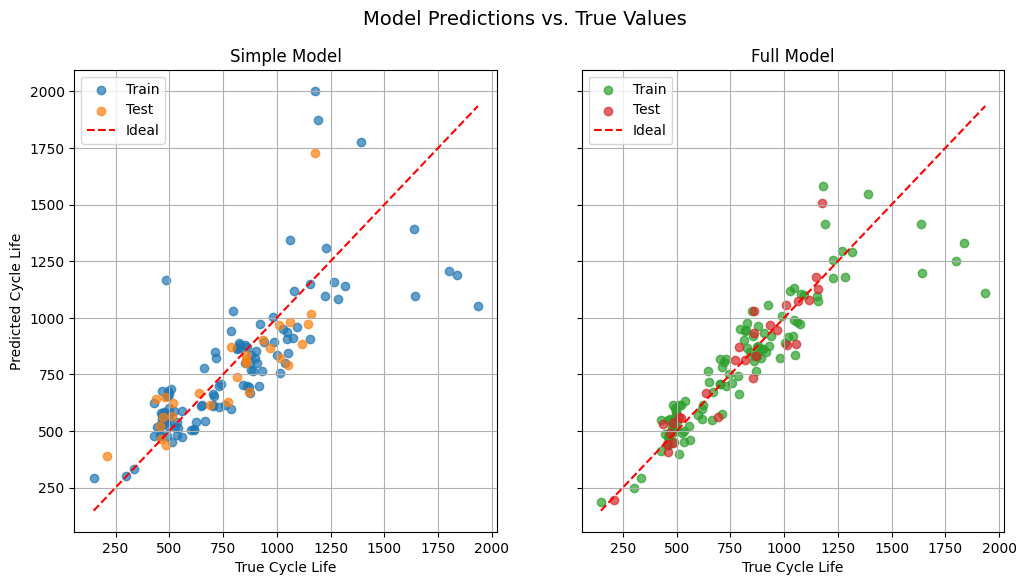

In [50]:
import matplotlib.pyplot as plt
import numpy as np

fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharex=True, sharey=True)

# Plot for simple model (left)
axes[0].scatter(np.exp(y_train), y_pred_train_simple, alpha=0.7, label='Train', color='tab:blue')
axes[0].scatter(y_true, y_pred_test_simple, alpha=0.7, label='Test', color='tab:orange')
axes[0].plot([min(np.exp(y_train)), max(np.exp(y_train))], 
             [min(np.exp(y_train)), max(np.exp(y_train))], 'r--', label='Ideal')
axes[0].set_title("Simple Model")
axes[0].set_xlabel("True Cycle Life")
axes[0].set_ylabel("Predicted Cycle Life")
axes[0].legend()
axes[0].grid(True)

# Plot for full model (right)
axes[1].scatter(np.exp(y_train), y_pred_train_full, alpha=0.7, label='Train', color='#2ca02c')  # pleasing green
axes[1].scatter(y_true, y_pred_test_full, alpha=0.7, label='Test', color='#d62728')  # pleasing red
axes[1].plot([min(np.exp(y_train)), max(np.exp(y_train))], 
             [min(np.exp(y_train)), max(np.exp(y_train))], 'r--', label='Ideal')
axes[1].set_title("Full Model")
axes[1].set_xlabel("True Cycle Life")
axes[1].legend()
axes[1].grid(True)

plt.suptitle("Model Predictions vs. True Values", fontsize=14);

So, the full model has fewer large deviations overall, but both models still fail to accurately predict the lifespans of long-lived cells. 

## Feature Importance Investigation🕵️‍♀️

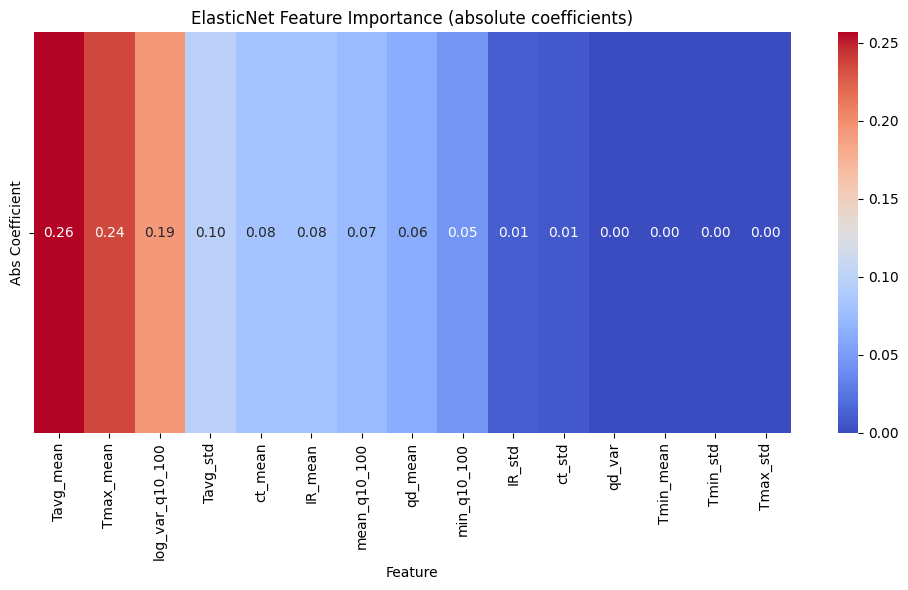

In [51]:
import seaborn as sns
import pandas as pd

feature_names = [
    "qd_mean", "qd_var", 
    "IR_mean", "IR_std", 
    "ct_mean", "ct_std", 
    "Tavg_mean", "Tmin_mean", "Tmax_mean", 
    "Tavg_std", "Tmin_std", "Tmax_std", 
    "min_q10_100", "mean_q10_100", "log_var_q10_100"
]

coefs = model_full.coef_
importance_df = pd.DataFrame({
    "Feature": feature_names,
    "Coefficient": coefs,
    "Abs Coefficient": np.abs(coefs)
}).sort_values("Abs Coefficient", ascending=False)

plt.figure(figsize=(10, 6))
sns.heatmap(importance_df.set_index("Feature")[["Abs Coefficient"]].T, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("ElasticNet Feature Importance (absolute coefficients)")
plt.tight_layout()
plt.show()

So in the more feature-rich full model, some of the temperature features become very important. However, we see that the 10th-100th cycle variance from the simple model is still a prominent feature as well. 